In [1]:
# Import section

import numpy as np
import matplotlib.pyplot as plt
import librosa
import madmom
import seaborn as sns
import re
from matplotlib import ticker

In [2]:
#%matplotlib notebook
sns.set_theme(context='paper')
colors = sns.color_palette("Blues", as_cmap=True)

In [3]:
# Feature extraction parameters

sr = 44100          #Sampling rate
fs = 2048           #Frame size
fps = 200           #Frames per second
window = np.hanning #Window for STFT
num_bands = 24      #Number of bands per octave
fmin = 27.5         #Minimum frequency
fmax = 16000        #Maximum frequency
diff_max_bins = 3

# Peak picking and evaluation parameters
threshold = 1.1
pre_max = 0.03
post_max = 0.03
pre_avg = 0.1
post_avg = 0.07
combine = 0.03 
delay = 0

In [20]:
# File parameters
title = 'ah_development_violin_my_violin1.flac'
audiofile = 'data/audio/' + title
annotationsfile = 'data/annotations/onsets/' + re.sub('\.flac$', '.onsets', title)
annotations = madmom.io.load_events(annotationsfile)

In [21]:
# Split signal into frames, perform STFT

signal, sr = librosa.load(audiofile, sr=sr, mono=True)
signal /= np.max(np.abs(signal))
signal = madmom.audio.signal.Signal(signal, sample_rate=sr, num_channels=1)
#signal = madmom.audio.stft.Signal(audiofile)
frames = madmom.audio.stft.FramedSignal(signal, frame_size=fs, fps=fps)
stft = madmom.audio.stft.ShortTimeFourierTransform(frames, window=window)

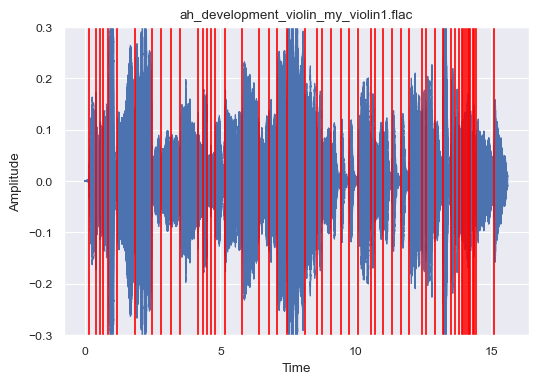

In [22]:
fig, ax = plt.subplots(figsize=(6, 4))
y, sr = librosa.load(audiofile, mono=True)
librosa.display.waveshow(y, sr=sr, ax=ax)
ax.eventplot(positions=annotations, lineoffsets=0, linelengths=0.6, color='#FF0000')
ax.set(title=title)
ax.set_ylabel("Amplitude")
#plt.xlim([0.0, 7.5])
plt.ylim([-0.3, 0.3])
ax.label_outer()
#plt.savefig("audio_with_onsets.png", bbox_inches="tight")

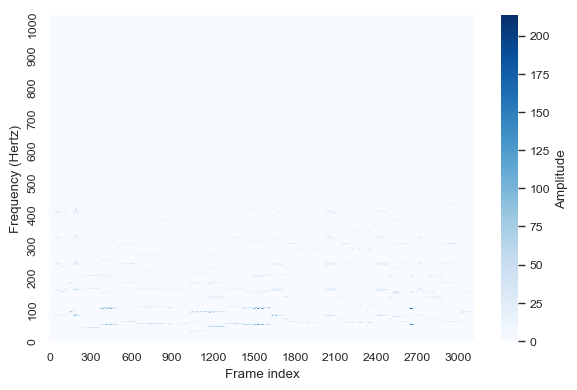

In [23]:
# Calculate spectogram


fig, axs = plt.subplots(figsize=(6, 4))
simplespec = madmom.audio.spectrogram.Spectrogram(stft)
sns.heatmap(data=simplespec.T, ax=axs, cmap=colors, cbar_kws={'label': 'Amplitude'}, xticklabels=300, yticklabels=100)
axs.invert_yaxis()

axs.set_xlabel("Frame index")
axs.set_ylabel("Frequency (Hertz)")
#axs.set_title(title)

#plt.savefig("sf1.png", bbox_inches="tight")
plt.tight_layout()

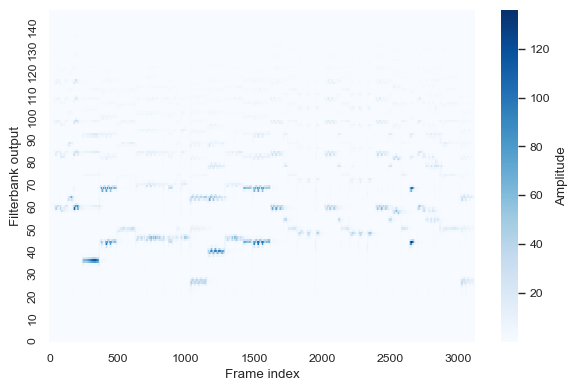

In [24]:
# Calculate filtered spectogram

fig, axs = plt.subplots(figsize=(6, 4))
filtered_spec = madmom.audio.spectrogram.FilteredSpectrogram(simplespec, num_bands=num_bands, fmin=fmin, fmax=fmax)
sns.heatmap(data=filtered_spec.T, ax=axs, cmap=colors, cbar_kws={'label': 'Amplitude'}, xticklabels=500, yticklabels=10)
axs.invert_yaxis()
axs.set_xlabel("Frame index")
axs.set_ylabel("Filterbank output")
#axs.set_title(title)
plt.savefig("sf2.png", dpi=300, bbox_inches="tight")
plt.tight_layout()

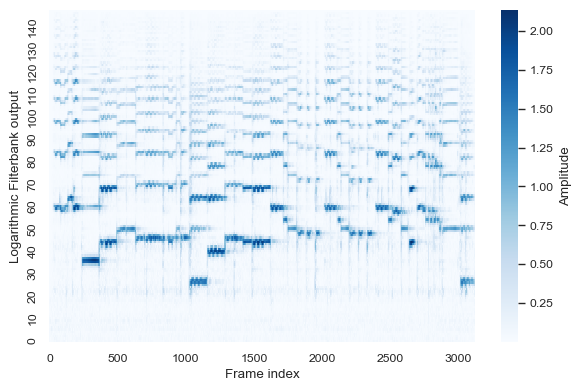

In [25]:
# Calculate logarithmic filtered spectogram

fig, axs = plt.subplots(figsize=(6, 4))
log_filtered_spec = madmom.audio.spectrogram.LogarithmicSpectrogram(filtered_spec)
sns.heatmap(data=log_filtered_spec.T, ax=axs, cmap=colors, cbar_kws={'label': 'Amplitude'}, xticklabels=500, yticklabels=10)
axs.invert_yaxis()
axs.set_xlabel("Frame index")
axs.set_ylabel("Logarithmic Filterbank output")
#axs.set_title(title)
plt.savefig("sf3.png", dpi=300, bbox_inches="tight") # option dpi=... oder als pdf
plt.tight_layout()

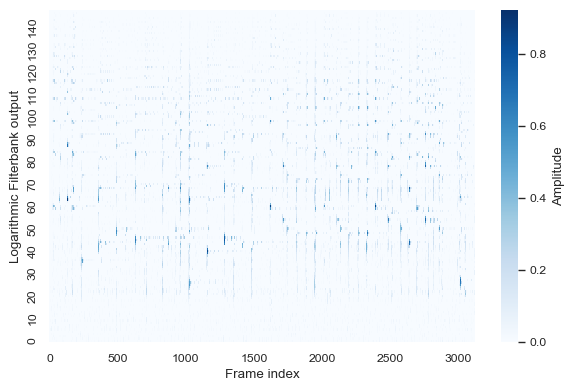

In [26]:
# Calculate positive spectogram differences

fig, axs = plt.subplots(figsize=(6, 4))
superflux = madmom.audio.spectrogram.SpectrogramDifference(log_filtered_spec, diff_max_bins=diff_max_bins, positive_diffs=True)

sns.heatmap(data=superflux.T, ax=axs, cmap=colors,cbar_kws={'label': 'Amplitude'}, xticklabels=500, yticklabels=10)
axs.invert_yaxis()
axs.set_xlabel("Frame index")
axs.set_ylabel("Logarithmic Filterbank output")
#axs.set_title("Maximumsgefiltertes Differenzspektrogram")
#axs.set_title(title)
plt.savefig("sf4.png", dpi=300, bbox_inches="tight")
plt.tight_layout()


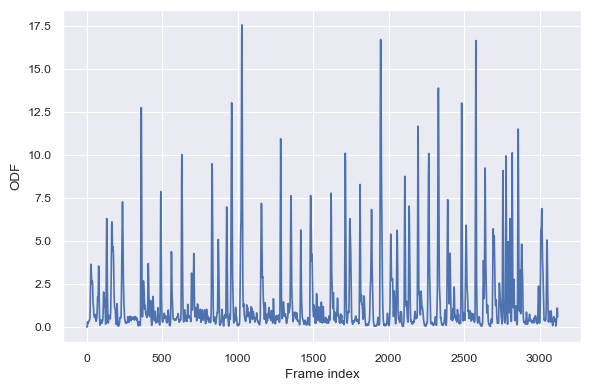

In [27]:
# Calculate ODF by summing up spectral differences

fig, axs = plt.subplots(figsize=(6, 4))
odf = superflux.sum(axis=1) # Aufsummieren/Integrieren
sns.lineplot(data=odf, ax=axs)
axs.set_xlabel("Frame index")
axs.set_ylabel("ODF")
#axs.eventplot(positions=annotations * 200, lineoffsets=70, linelengths=140)
#axs.set_title(title)
#axs.set_title("Onset-Detektionsfunktion")
plt.savefig("sf5.pdf", bbox_inches="tight")
plt.tight_layout()

In [148]:
# PeakPicking

proc = madmom.features.onsets.OnsetPeakPickingProcessor(threshold=threshold,
                                                        pre_max=pre_max,
                                                        post_max=post_max,
                                                        pre_avg=pre_avg,
                                                        post_avg=post_avg, 
                                                        combine=combine, 
                                                        delay=delay,
                                                        fps=fps)

onsets_sf = proc(odf)

In [149]:
# Evaluation
evl = madmom.evaluation.onsets.OnsetEvaluation(detections=onsets_sf,
                                               annotations=annotations,
                                               window=0.05,
                                               combine=0.03,
                                               delay=0)
print(evl)

Onsets:    57 TP:    55 FP:     2 FN:     2 Precision: 0.965 Recall: 0.965 F-measure: 0.965 mean:  -8.9 ms std:   6.6 ms


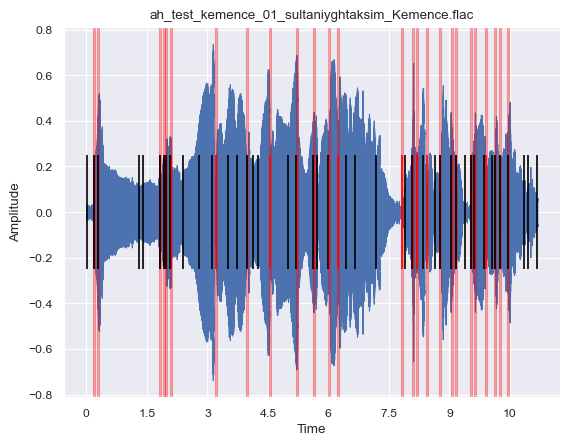

In [129]:
fig, ax = plt.subplots()
y, sr = librosa.load(audiofile, mono=True)
librosa.display.waveshow(y, sr=sr, ax=ax)
ax.eventplot(positions=annotations, lineoffsets=0, linelengths=0.5, color='#FF0000')
ax.eventplot(positions=onsets_sf, lineoffsets=0, linelengths=0.5, color='#000000')
#plt.axvspan(annotations[0]-0.025, annotations[0]+0.025, color='red', alpha=0.3)
for a in annotations:
    plt.axvspan(a-0.025, a+0.025, color='red', alpha=0.3)
#plt.xlim([0.0, 0.3])
#plt.ylim([-0.15, 0.15])
ax.set(title=title)
ax.set_ylabel("Amplitude")
ax.label_outer()
#plt.savefig("onset_tolerance.png", bbox_inches="tight")

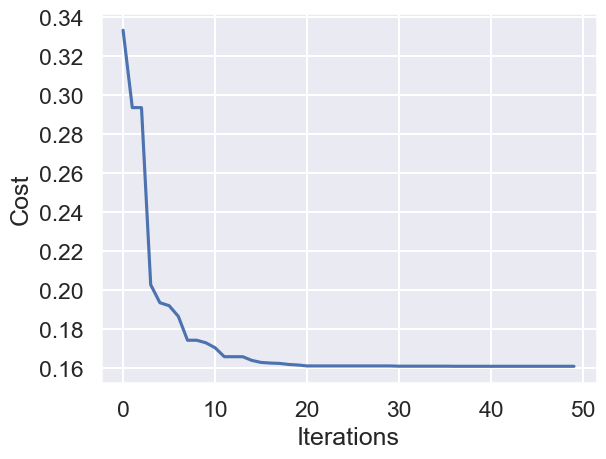

In [26]:
#cost_history = [0.33309420834211834, 0.28517790603845994, 0.28069939628378926, 0.26841133489805946, 0.23801734552251863, 0.19652234698099225, 0.19215926578493014, 0.18239363998899205, 0.18075827703467617, 0.16622713019998947, 0.16358911377317453, 0.16358911377317453, 0.16358911377317453, 0.1629211813186502, 0.16273470486208186, 0.16182395395163507, 0.16182395395163507, 0.1618047243363927, 0.1618047243363927, 0.1617151400205975, 0.1617151400205975, 0.1617151400205975, 0.16164472547677067, 0.16125586389451751, 0.16125586389451751, 0.16125586389451751, 0.16110587911065366, 0.16110587911065366, 0.16110587911065366, 0.16110587911065366, 0.16110587911065366, 0.16110587911065366, 0.16110587911065366, 0.16110587911065366, 0.16110587911065366, 0.16110587911065366, 0.16110587911065366, 0.16110587911065366, 0.16110587911065366, 0.16110587911065366, 0.16110587911065366, 0.16110587911065366, 0.16110587911065366, 0.16110587911065366, 0.16110587911065366, 0.16110587911065366, 0.16110587911065366, 0.16110587911065366, 0.16110587911065366, 0.16110587911065366]
cost_history = [0.3333881444515979, 0.29372563201828494, 0.29372563201828494, 0.20291576446138349, 0.193678199670285, 0.19217753149647399, 0.1867112703309004, 0.17444186612485246, 0.17444186612485246, 0.173130956324951, 0.1705768263796842, 0.16599404097732162, 0.16599404097732162, 0.16599404097732162, 0.1640911868305328, 0.16306149421469174, 0.1627458901111688, 0.16256113754879242, 0.16202302646598898, 0.1617391567022114, 0.16126253688030556, 0.16126253688030556, 0.16126253688030556, 0.16126253688030556, 0.16126253688030556, 0.16126253688030556, 0.16126253688030556, 0.16126253688030556, 0.16126253688030556, 0.16126253688030556, 0.16113516270254802, 0.16113516270254802, 0.16113516270254802, 0.16113516270254802, 0.16113516270254802, 0.16113516270254802, 0.1610873774993219, 0.1610873774993219, 0.1610873774993219, 0.1610873774993219, 0.1610873774993219, 0.1610873774993219, 0.1610873774993219, 0.1610873774993219, 0.1610873774993219, 0.1610873774993219, 0.1610873774993219, 0.1610873774993219, 0.1610873774993219, 0.1610873774993219]
fig, axs = plt.subplots()
axs.set_ylabel("Cost")
axs.set_xlabel("Iterations")
axs.yaxis.set_major_locator(ticker.MultipleLocator(0.02))
plt.plot(cost_history)
plt.savefig("cost_history.png", bbox_inches="tight")